### House Prices - Advanced Regression Techniques
#### Introduction

This notebook implements a machine learning pipeline to predict house prices using the Kaggle "House Prices - Advanced Regression Techniques" dataset. We'll explore feature engineering, preprocessing, and various regression models including Random Forests and Gradient Boosting.

1. Data Loading and Initial Exploration
First, we load the necessary libraries and the dataset:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Initial exploration
print(train.info())
print(train.describe())

c:\Users\2004a\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Handling Missing Values
- Used `SimpleImputer` with:
  - `strategy='median'` for numeric features
  - `strategy='constant'` with `fill_value='missing'` for categoricals

### Target Variable Transformation
- Applied log transformation to `SalePrice`:
  ```python
  train['SalePrice'] = np.log1p(train['SalePrice'])

2. Feature Engineering

We create several new features that might help our model:

In [10]:
def feature_engineering(df):
    # Combine existing features
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    
    # Age features
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    
    # Boolean features
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    
    # Quality interactions
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    
    return df

train = feature_engineering(train)
test = feature_engineering(test)

3. Target Variable Transformation

We apply a log transformation to the target variable to handle its right-skewed distribution:

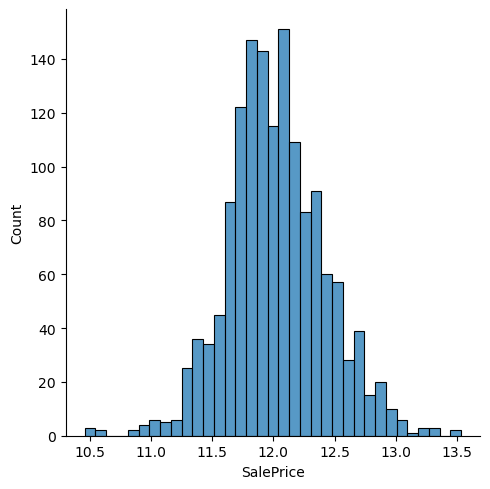

In [16]:
# SalePrice is typically right-skewed
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.displot(train['SalePrice'])

4. Data Preprocessing Pipeline

We create a comprehensive preprocessing pipeline to handle both numeric and categorical features:

In [11]:
# Separate target and features
y_train = np.log1p(train['SalePrice'])  # Log transformation for normality
X_train = train.drop(['Id', 'SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

5. Model Training and Evaluation

We split the data and evaluate our initial model:


In [12]:
# Split data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Fit the model
pipeline.fit(X_train_split, y_train_split)

# Evaluate
def evaluate_model(model, X, y):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    print(f"RMSE: {rmse:.4f}")
    return rmse

print("Training performance:")
train_rmse = evaluate_model(pipeline, X_train_split, y_train_split)

print("\nValidation performance:")
val_rmse = evaluate_model(pipeline, X_val_split, y_val_split)

Training performance:
RMSE: 0.0743

Validation performance:
RMSE: 0.1401


6. Advanced Model Tuning

We perform grid search to find optimal hyperparameters:

In [13]:
# Define parameter grid for Gradient Boosting
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5],
    'regressor__min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best CV RMSE: 0.1289


In [5]:
def add_features(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    return df

train = add_features(train)
test = add_features(test)

7. Ensemble Approach

We compare multiple advanced algorithms:

In [14]:
# Define multiple models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Create pipeline with current model
    current_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train and evaluate
    current_pipeline.fit(X_train_split, y_train_split)
    train_rmse = evaluate_model(current_pipeline, X_train_split, y_train_split)
    val_rmse = evaluate_model(current_pipeline, X_val_split, y_val_split)
    
    results[name] = {'train_rmse': train_rmse, 'val_rmse': val_rmse}

# Compare results
results_df = pd.DataFrame(results).T
print(results_df)

RMSE: 0.0520
RMSE: 0.1457
RMSE: 0.0052
RMSE: 0.1441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4337
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 203
[LightGBM] [Info] Start training from score 12.030658
RMSE: 0.0111
RMSE: 0.1378
              train_rmse  val_rmse
RandomForest    0.051980  0.145654
XGBoost         0.005158  0.144138
LightGBM        0.011133  0.137756


In [15]:
# Train final model on all training data
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Make predictions on test set
test_preds = np.expm1(final_model.predict(X_test))  # Reverse log transformation

# Create submission file
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test_preds
})
submission.to_csv('submission.csv', index=False)